In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy import linalg
from matplotlib import colors

In [2]:
def generate_dataset(mus, sigmas, class_samples_size, save_path):
    dataset = pd.DataFrame(data={'X1': [], 'X2': [], 'Y':[]})
    for i in range(len(mus)):
        x1, x2 = np.random.multivariate_normal(mus[i], sigmas[i], class_samples_size).T
        ds_class_i = pd.DataFrame(data={'X1': x1, 'X2': x2, 'Y': [i] * class_samples_size})
        dataset = pd.concat([dataset, ds_class_i], axis=0)
    dataset.to_csv(save_path, index=False)
    return dataset

# ----> Run once to generate data <----
mu_ds_1 = \
    [[3, 6],
    [5, 4],
    [6, 6]]

sigma_ds_1 = \
    [[[1.5, 0], [0, 1.5]],
    [[2, 0], [0, 2]],
    [[1, 0], [0, 1]]]

mu_ds_2 = \
    [[3, 6],
    [5, 4],
    [6, 6]]

sigma_ds_2 = \
    [[[1.5, 0.1], [0.1, 0.5]],
    [[1, -0.20], [-0.20, 2]],
    [[2, -0.25], [-0.25, 1.5]]]

# generate_dataset(mu_ds_1, sigma_ds_1, 500, 'datasets/QDA_dataset1.csv')
# generate_dataset(mu_ds_2, sigma_ds_2, 500, 'datasets/QDA_dataset2.csv')

In [3]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    train_data, test_data = train_test_split(data, test_size=0.2, stratify = data['Y'])
    X_train = np.array(train_data[['X1','X2']])
    y_train = np.array(train_data['Y'])
    X_test = np.array(test_data[['X1','X2']])
    y_test = np.array(test_data['Y'])
    return X_train, X_test, y_train, y_test 

def compute_priors(y, labels):
    priors = np.zeros(labels.size)
    for i, label in enumerate(labels):
        priors[i] = y[y == label].size / y.size
    return priors

def compute_means(X, y, labels):
    means = []
    for i, label in enumerate(labels):
        means.append(np.mean(X[y == label], axis=0))
    return means

def compute_sigmas(X, y, means, classes):
    # sigma = np.zeros(shape=(X.shape[1], X.shape[1]))
    sigmas = []
    for i, label in enumerate(classes):
        x_demeam = X[y == label] - means[i]
        sigma = np.cov(x_demeam.T)
        # sigma = (x_demeam).T.dot(x_demeam) / (X.shape[0])
        sigmas.append(sigma)

    return np.array(sigmas) # return cov if single

def compute_probability(X, sigma, prior, mean):
    x_demean = X - mean
    # xmu_covariance = (x_demeam @ np.linalg.pinv(sigma)) @ x_demeam.T
    x_demean_covariance = (x_demean.dot(np.linalg.pinv(sigma))) * x_demean
    x_demean_cov_sum= x_demean_covariance.sum(axis=1)
    return -(1/2) * x_demean_cov_sum - (1/2) * np.log(np.linalg.det(sigma)) + np.log(prior)

def compute_probabilities(X, sigmas, priors, means, classes):
    probabilities = np.zeros((X.shape[0], priors.size))
    for i,_ in enumerate(classes):
        probabilities[:, i] = compute_probability(X, sigmas[i], priors[i], means[i])
    return probabilities

def get_confusion_matrix(estimates, test_labels, priors):
    num_confusion_matrix = [[0 for x in range(len(priors))] for x in range(len(priors))]
    for i, value in enumerate(estimates): 
        row = int(test_labels[i])
        column = int(value)
        num_confusion_matrix[row][column] += 1
    
    num_confusion_matrix = np.array(num_confusion_matrix)
    return num_confusion_matrix

def predict(probabilities):
    return np.argmax(probabilities, axis=1)

In [4]:
def cal_accuracy(confusion_matrix, total_labels):
    true_sum = np.sum(np.diag(confusion_matrix))
    
    accuracy = true_sum / total_labels 
    return accuracy

def cal_precisions(confusion_matrix):
    return np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)

def cal_recalls(confusion_matrix):
    return np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)

def cal_f1_scores(recalls, percisions):
    return 2 * ((recalls * percisions) / (recalls + percisions))

def report_results(confusion_matrix, total_labels, labels_no, title):
    print('-'*15 + ' ' + title + ' '+ '-'*15)
    recalls = cal_recalls(confusion_matrix).flatten()
    percisions = cal_precisions(confusion_matrix).flatten()
    f1_scores = cal_f1_scores(recalls, percisions).flatten()
    print ("{:<8} {:<15} {:<15} {:<15}".format('Class', 'Recall', 'Precision', 'F1 Scores'))
    for i in range(labels_no):
        print ("{:<8} {:<15} {:<15} {:<15}".format(str(i),\
            str(round((recalls[i] * 100), 2)), round((percisions[i] * 100), 2), round((f1_scores[i] * 100), 2)))
    print("Accuracy: ",  round((cal_accuracy(confusion_matrix, total_labels) * 100), 2), "%")
    print('-'*60)

In [5]:

import warnings

def plot_3D_pdfs(X_data, y_data, labels, priors, mus, sigmas, title):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))

    colors = ['viridis', 'cividis', 'magma']
    for label in range(len(labels)):
        X_by_class = X_data[(y_data == label).flatten()]
        X, Y = np.mgrid[
            np.min(X_by_class[:, 0]):np.max(X_by_class[:, 0]):.01, 
            np.min(X_by_class[:, 1]):np.max(X_by_class[:, 1]):.01
        ]
        pos = np.dstack((X, Y))
        mu = np.asarray(mus[label]).flatten()
        
        Z = multivariate_normal(mu, sigmas[label]).pdf(pos)
        ax.plot_surface(X, Y, Z, cmap=colors[label], linewidth=0.2, alpha=0.9, shade=True)

    plt.title(title)
    plt.show()

def solve_quadratic_eq(_a, _b, _c, x0):
    a = _a[1][1]
    b = x0*(_a[1][0] + _a[0][1]) + _b[1]
    c = (x0**2) * _a[0][0] + x0 * _b[0] + _c

    if(b**2 - 4*a*c >= 0):
        return [((-b - np.sqrt(b**2 - 4*a*c))/(2 * a)), ((-b + np.sqrt(b**2 - 4*a*c)) / (2 * a))]
    return None

def plot_decision_boundary_line(ax, X_data, y_data, labels, mus, priors, sigmas):
    cs = ['red', 'blue', 'green']
    for label1 in range(len(labels)):
        for label2 in labels[labels < label1]:
            sigma1_inverse = np.linalg.inv(sigmas[label1])
            sigma2_inverse = np.linalg.inv(sigmas[int(label2)])
            det1 = np.linalg.det(sigmas[label1])
            det2 = np.linalg.det(sigmas[int(label2)])
            a = -(1/2) * (sigma1_inverse-sigma2_inverse)
            b = (sigma1_inverse @ mus[label1].T) - (sigma2_inverse@mus[int(label2)].T)
            c = (np.log(priors[label1]/priors[int(label2)]) +
                (-(1/2) * (np.log(det1/det2))) +
                (-(1/2) * (mus[label1]@sigma1_inverse) @ mus[label1].T) +
                ((1/2) * (mus[int(label2)] @ sigma2_inverse) @ mus[int(label2)].T))
            min_x0 = np.min(np.concatenate((X_data[y_data == label1][:, 0], X_data[y_data == label2][:, 0])))
            max_x0 = np.max(np.concatenate((X_data[y_data == label1][:, 0], X_data[y_data == label2][:, 0])))
            x0 = []
            x1_u = []
            x1_d = []
            for x in np.arange(min_x0-0.5, max_x0+0.5, 0.1):
                eq_answers = solve_quadratic_eq(a, b, c, x)
                if eq_answers is not None:
                    x0.append(x)
                    x1_u.append(eq_answers[0])
                    x1_d.append(eq_answers[1])
            x0_nw = np.concatenate((x0, x0[::-1]))
            x1_nw = np.concatenate((x1_d, x1_u[::-1]))
            ax.plot(x0_nw, x1_nw, '-')
            # plt.fill_between(x0_nw, x1_nw,color='k',alpha=.5)

def plot_scatter(X_data, y_data, predicted_input, labels, priors, mus, sigmas, title=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    correct_classifications = []
    missed_classifications = []

    for label in range(len(labels)):
        correct_classifications.append(X_data[np.logical_and(predicted_input == y_data, y_data == label)])
        missed_classifications.append(X_data[np.logical_and(predicted_input != y_data, y_data == label)])
        ax.plot(correct_classifications[label][:, 0], correct_classifications[label][:, 1], '.')
        ax.plot(missed_classifications[label][:, 0], missed_classifications[label][:, 1], 'x')

    plot_decision_boundary_line(ax, X_data, y_data, labels, mus, priors, sigmas)
    
    plt.xlim(np.min(X_data[:, 0]) * 1.2, np.max(X_data[:, 0]) * 1.2)
    plt.ylim(np.min(X_data[:, 0]) * 1.2, np.max(X_data[:, 1]) * 1.2)
    plt.title(title)
    plt.show()

def plot_contour(X_data, y_data, labels, mus, priors, sigmas, title):
    fig, ax = plt.subplots(figsize=(8, 6))

    for label in range(len(labels)):
        X_by_class = X_data[(y_data == label).flatten()]
        X, Y = np.mgrid[
            np.min(X_by_class[:, 0]):np.max(X_by_class[:, 0]):.01, 
            np.min(X_by_class[:, 1]):np.max(X_by_class[:, 1]):.01
        ]
        pos = np.dstack((X, Y))
        Z = multivariate_normal(mus[label], sigmas[label]).pdf(pos)
        ax.contour(X, Y, Z)
        
    plot_decision_boundary_line(ax, X_data, y_data, labels, mus, priors, sigmas)
    plt.xlim(np.min(X_data[:, 0]) * 1.2, np.max(X_data[:, 0]) * 1.2)
    plt.ylim(np.min(X_data[:, 0]) * 1.2, np.max(X_data[:, 1]) * 1.2)
    plt.title(title)
    plt.show()

--------------- Dataset (1) - Train Results ---------------
Class    Recall          Precision       F1 Scores      
0        80.75           81.57           81.16          
1        64.75           74.0            69.07          
2        81.25           71.59           76.11          
Accuracy:  75.58 %
------------------------------------------------------------


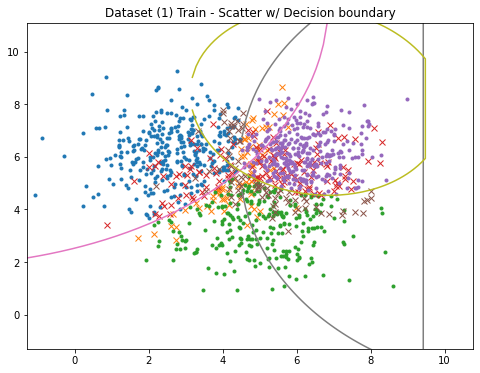

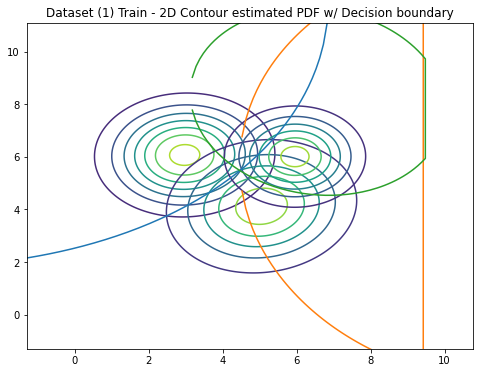

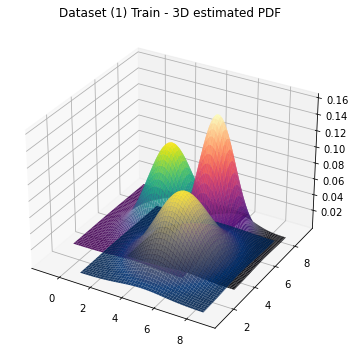

--------------- Dataset (1) - Test Results ---------------
Class    Recall          Precision       F1 Scores      
0        83.0            83.0            83.0           
1        65.0            70.65           67.71          
2        80.0            74.07           76.92          
Accuracy:  76.0 %
------------------------------------------------------------


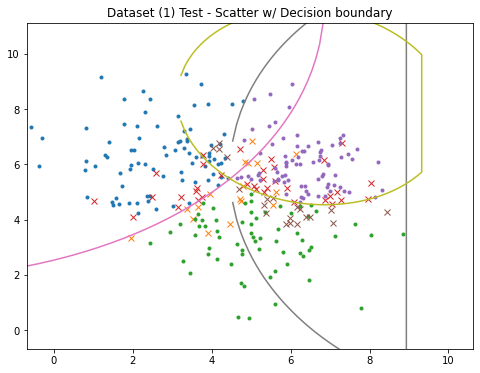

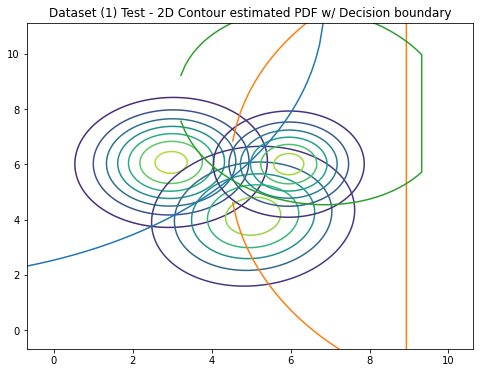

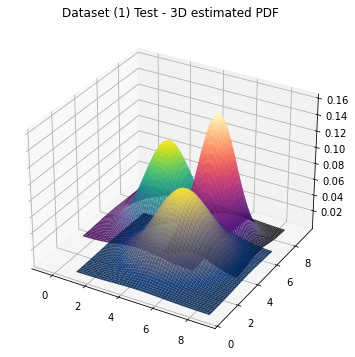

--------------- Dataset (2) - Train Results ---------------
Class    Recall          Precision       F1 Scores      
0        89.75           82.53           85.99          
1        78.25           81.72           79.95          
2        75.5            79.06           77.24          
Accuracy:  81.17 %
------------------------------------------------------------


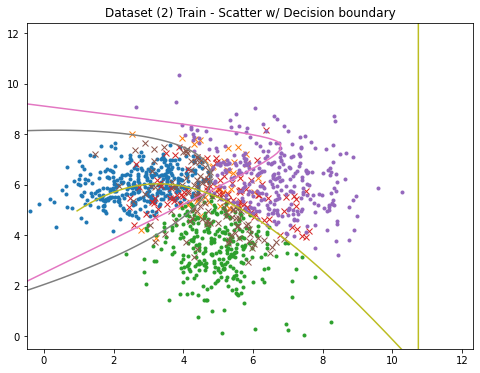

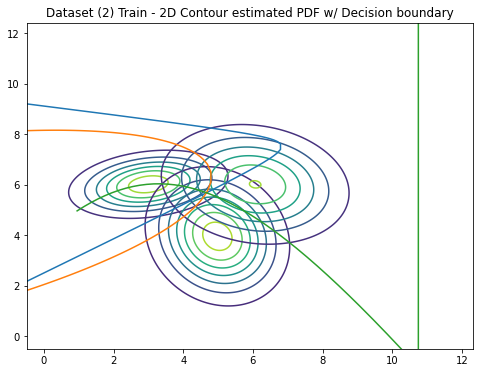

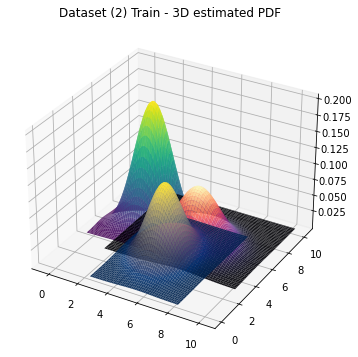

--------------- Dataset (2) - Test Results ---------------
Class    Recall          Precision       F1 Scores      
0        91.0            81.98           86.26          
1        83.0            81.37           82.18          
2        75.0            86.21           80.21          
Accuracy:  83.0 %
------------------------------------------------------------


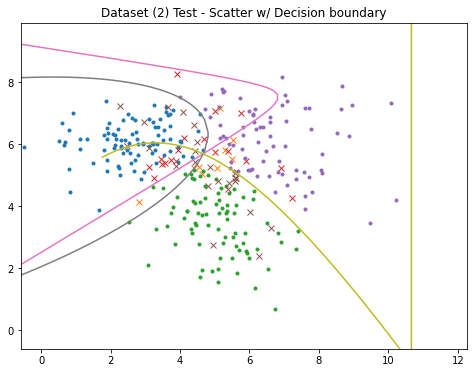

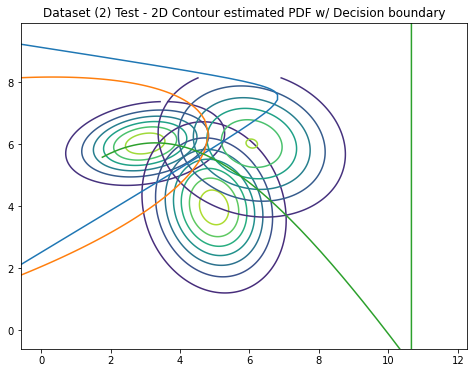

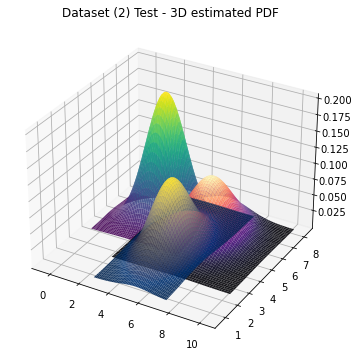

In [6]:
for i in range(2):
    # Data pre-processing
    X_train, X_test, y_train, y_test = load_data(f'datasets/QDA_dataset{i+1}.csv')
    # Training
    unique_classes, classes_count = np.unique(y_train, return_counts=True)
    unique_classes.sort()
    priors = compute_priors(y_train, unique_classes)
    means = compute_means(X_train, y_train, unique_classes)
    sigmas = compute_sigmas(X_train, y_train, means, unique_classes)

    train_probs = compute_probabilities(X_train, sigmas, priors, means, unique_classes)
    train_predictions = predict(train_probs)
    train_cm = get_confusion_matrix(train_predictions, y_train, priors)
    report_results(train_cm, y_train.shape[0], len(classes_count), f"Dataset ({i+1}) - Train Results") 
    plot_scatter(X_train, y_train, train_predictions, unique_classes, priors, means, sigmas, \
        f'Dataset ({i+1}) Train - Scatter w/ Decision boundary')
    plot_contour(X_train, y_train, unique_classes, means, priors, sigmas, \
        f'Dataset ({i+1}) Train - 2D Contour estimated PDF w/ Decision boundary')
    plot_3D_pdfs(X_train, y_train, unique_classes, priors, means, sigmas, \
        f'Dataset ({i+1}) Train - 3D estimated PDF')

    test_probs = compute_probabilities(X_test, sigmas, priors, means, unique_classes)
    test_predictions = predict(test_probs)
    test_cm = get_confusion_matrix(test_predictions, y_test, priors)
    report_results(test_cm, y_test.shape[0], len(classes_count), f"Dataset ({i+1}) - Test Results") 
    plot_scatter(X_test, y_test, test_predictions, unique_classes, priors, means, sigmas, \
        f'Dataset ({i+1}) Test - Scatter w/ Decision boundary')
    plot_contour(X_test, y_test, unique_classes, means, priors, sigmas, \
        f'Dataset ({i+1}) Test - 2D Contour estimated PDF w/ Decision boundary')
    plot_3D_pdfs(X_test, y_test, unique_classes, priors, means, sigmas, \
        f'Dataset ({i+1}) Test - 3D estimated PDF')